# A Basic MLP

This example shows the possibility of building a simple MLP in rendervous using composition of maps.

In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav==13.1.0
    !pip install git+https://github.com/rendervous/rendervous_project.git
except:
    print("Executing locally")

Executing locally


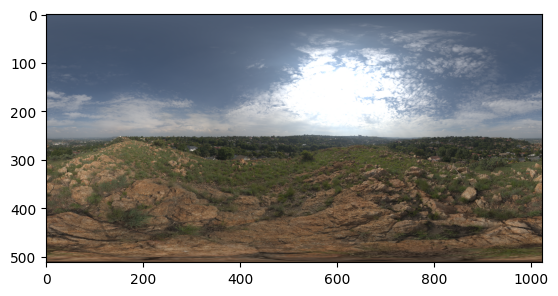

In [2]:
import rendervous as rdv
import vulky.datasets as datasets
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


# load the example image
# im = rdv.load_image('reconstructed_cloud.png')[..., 0:3].to(rdv.device())
im = datasets.Images.environment_example.cuda()
im = torch.clamp(im ** (1.0/2.2), 0.0, 1.0)

plt.imshow(im.cpu())
plt.show()

Loss: 0.005477277096360922: 100%|██████████| 4000/4000 [03:54<00:00, 17.03it/s] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14961605..1.0839984].


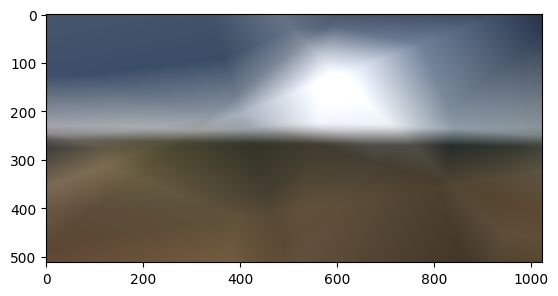

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14961605..1.0839984].


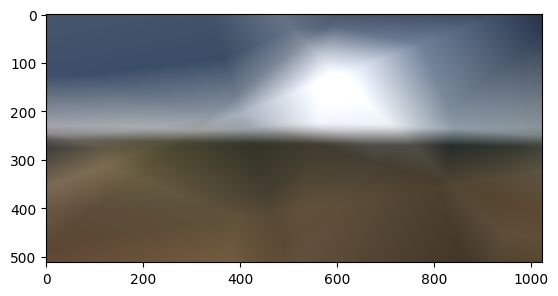

In [3]:
def dense(input_dim, output_dim):
    k = 1 / input_dim
    A_0 = torch.nn.Parameter((torch.rand(output_dim, input_dim, device=rdv.device())*2 - 1)*np.sqrt(k))
    B_0 = torch.nn.Parameter((2 * torch.rand(output_dim, device=rdv.device())-1)*np.sqrt(k))
    return A_0 @ rdv.X + rdv.const[B_0]

maps = [dense(2, 16), rdv.relu, dense(16, 16), rdv.relu, dense(16, 3)]

mlp_eval = rdv.Sequential(*maps)
mlp = maps[0].then(maps[1]).then(maps[2]).then(maps[3]).then(maps[4])
# mlp = dense(2, 16).then(rdv.relu).then(dense(16, 16)).then(rdv.relu).then(dense(16, 3))

optimizer = torch.optim.NAdam(mlp.parameters(), lr=0.002)

x = torch.cartesian_prod(
    torch.arange(-1.0, 1.0, 2.0 / im.shape[0], device=rdv.device()),
    torch.arange(-1.0, 1.0, 2.0 / im.shape[1], device=rdv.device())
).view(im.shape[0], im.shape[1], -1)

mlp(x)  # prewarm
mlp_eval(x)  #prewarm

# Evaluation time
with torch.no_grad():
    for test in tqdm(range(1000)):
        y = mlp(x)
        torch.cuda.empty_cache()
    
    for test in tqdm(range(1000)):
        y = mlp_eval(x)
        torch.cuda.empty_cache()
    
steps_iterator = tqdm(range(4000))
for s in steps_iterator:
    optimizer.zero_grad()
    inf_y = mlp(x)
    loss = torch.nn.functional.mse_loss(inf_y, im)
    loss.backward()
    optimizer.step()

    steps_iterator.set_description_str(f"Loss: {loss.item()}")

with torch.no_grad():
    plt.imshow(mlp(x).cpu())
    plt.show()
    plt.imshow(mlp_eval(x).cpu())
    plt.show()

In [ ]:
# Equivalent torch mlp

mlp = torch.nn.Sequential(
    torch.nn.Linear(2, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 3)
).to(rdv.device())

optimizer = torch.optim.NAdam(mlp.parameters(), lr=0.002)

x = torch.cartesian_prod(
    torch.arange(-1.0, 1.0, 2.0 / im.shape[0], device=rdv.device()),
    torch.arange(-1.0, 1.0, 2.0 / im.shape[1], device=rdv.device())
).view(im.shape[0], im.shape[1], -1)

# Evaluation time
for test in tqdm(range(10000)):
    y = mlp(x)
    torch.cuda.empty_cache()

steps_iterator = tqdm(range(4000))
for s in steps_iterator:
    optimizer.zero_grad()
    inf_y = mlp(x)
    loss = torch.nn.functional.mse_loss(inf_y, im)
    loss.backward()
    optimizer.step()

    steps_iterator.set_description_str(f"Loss: {loss.item()}")

with torch.no_grad():
    plt.imshow(mlp(x).cpu())
    plt.show()